In [322]:
import sklearn as sk
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [323]:
# Loading data and check if it's loaded properly
df = pd.read_csv("Paitients_Files_Train.csv", delimiter=",")
print(df.head(5))

          ID  PRG   PL  PR  SK   TS   M11    BD2  Age  Insurance   Sepssis
0  ICU200010    6  148  72  35    0  33.6  0.627   50          0  Positive
1  ICU200011    1   85  66  29    0  26.6  0.351   31          0  Negative
2  ICU200012    8  183  64   0    0  23.3  0.672   32          1  Positive
3  ICU200013    1   89  66  23   94  28.1  0.167   21          1  Negative
4  ICU200014    0  137  40  35  168  43.1  2.288   33          1  Positive


In [324]:
# drop 2 irrelevant columns: ID and Insurance
df.drop(columns="ID", inplace=True)
df.drop(columns="Insurance", inplace=True)

In [325]:
X = df.drop(columns="Sepssis")
Y = df[["Sepssis"]]

In [326]:
Y.value_counts()

Sepssis 
Negative    391
Positive    208
dtype: int64

In [327]:
import numpy as np
for col in X.columns:
    percentiles = X[col].quantile([0.01, 0.99]).values
    df[col] = np.clip(X[col], percentiles[0], percentiles[1])

In [328]:
Y.value_counts()

Sepssis 
Negative    391
Positive    208
dtype: int64

In [329]:
# spliting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=6, test_size=0.2)
print("Training X:", X_train.shape)
print("Testing X: ",X_test.shape)
print("Train Y: ",y_train.shape)

Training X: (479, 8)
Testing X:  (120, 8)
Train Y:  (479, 1)


In [330]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
dtf = DecisionTreeClassifier(criterion="gini",max_features=5/6, max_depth=5,
random_state=3, class_weight={"Negative":0.22, "Positive": 0.78})
# fit model

dtf.fit(X_train, y_train)
# make predictions

yhat = dtf.predict(X_test)

# calculate accuracy

accuracy = metrics.accuracy_score(yhat, y_test)

print('Accuracy: %.3f' % dtf.score(X_test, y_test))

Accuracy: 0.767


In [331]:
text_ = tree.export_text(dtf,feature_names=['BGlucose', 'B1', 'BPressure', 'B2', 'B3', 'BMI', 'B4', 'Age'])
print(text_)

|--- BMI <= 28.85
|   |--- Age <= 27.50
|   |   |--- BGlucose <= 2.50
|   |   |   |--- class: Negative
|   |   |--- BGlucose >  2.50
|   |   |   |--- B4 <= 0.40
|   |   |   |   |--- class: Negative
|   |   |   |--- B4 >  0.40
|   |   |   |   |--- B2 <= 15.50
|   |   |   |   |   |--- class: Positive
|   |   |   |   |--- B2 >  15.50
|   |   |   |   |   |--- class: Negative
|   |--- Age >  27.50
|   |   |--- B3 <= 112.00
|   |   |   |--- Age <= 62.50
|   |   |   |   |--- Age <= 58.50
|   |   |   |   |   |--- class: Negative
|   |   |   |   |--- Age >  58.50
|   |   |   |   |   |--- class: Positive
|   |   |   |--- Age >  62.50
|   |   |   |   |--- class: Negative
|   |   |--- B3 >  112.00
|   |   |   |--- BPressure <= 61.00
|   |   |   |   |--- class: Negative
|   |   |   |--- BPressure >  61.00
|   |   |   |   |--- BPressure <= 83.00
|   |   |   |   |   |--- class: Positive
|   |   |   |   |--- BPressure >  83.00
|   |   |   |   |   |--- class: Negative
|--- BMI >  28.85
|   |--- Age <= 

In [332]:
f_probs = dtf.predict_proba(X_test)
f_probs = f_probs[:,1]
print(metrics.roc_auc_score(y_test, f_probs))

0.7880658436213992


              precision    recall  f1-score   support

    Negative       0.88      0.75      0.81        81
    Positive       0.61      0.79      0.69        39

    accuracy                           0.77       120
   macro avg       0.75      0.77      0.75       120
weighted avg       0.79      0.77      0.77       120



<AxesSubplot:>

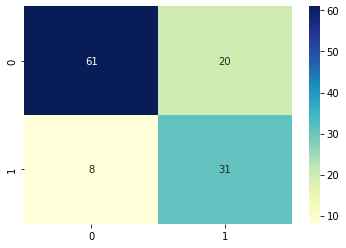

In [333]:
print(metrics.classification_report(y_test, yhat))
fr_pred = dtf.predict(X_test)
cnf_matrix = confusion_matrix(y_test, fr_pred)
class_names=["Positive","Negative"] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')

In [335]:
# define pipeline
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN, SVMSMOTE, SMOTE
steps = [('over', ADASYN()), ('model', dtf)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X_train, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
score = mean(scores)
print('F1 Score: %.3f' % score)

F1 Score: 0.629


# Random Forest

In [337]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_features=5/6,random_state=3,class_weight={"Negative":0.22, "Positive": 0.78})
rf.fit(X_train, y_train.to_numpy().ravel())

RandomForestClassifier(class_weight={'Negative': 0.22, 'Positive': 0.78},
                       max_features=0.8333333333333334, random_state=3)

In [338]:
rf_probs = rf.predict_proba(X_test)

rf_probs = rf_probs[:, 1]
rf_auc = roc_auc_score(y_test, rf_probs)
print('Random Forest: AUROC = %.3f' % (rf_auc))


Random Forest: AUROC = 0.808


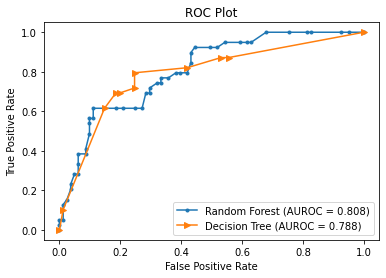

In [343]:
from sklearn.metrics import roc_curve, roc_auc_score

rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs, pos_label="Positive")
fpr, tpr, _ = roc_curve(y_test, f_probs,pos_label="Positive")
auc = roc_auc_score(y_test, f_probs)

plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest (AUROC = %0.3f)' % rf_auc)
plt.plot(fpr, tpr, marker=">", label='Decision Tree (AUROC = %0.3f)' % auc)

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

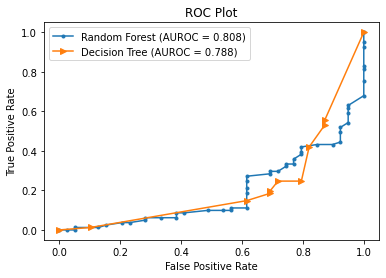

In [344]:
from sklearn.metrics import roc_curve, roc_auc_score

rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs, pos_label="Negative")
fpr, tpr, _ = roc_curve(y_test, f_probs,pos_label="Negative")
auc = roc_auc_score(y_test, f_probs)

plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest (AUROC = %0.3f)' % rf_auc)
plt.plot(fpr, tpr, marker=">", label='Decision Tree (AUROC = %0.3f)' % auc)

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

              precision    recall  f1-score   support

    Negative       0.83      0.89      0.86        81
    Positive       0.73      0.62      0.67        39

    accuracy                           0.80       120
   macro avg       0.78      0.75      0.76       120
weighted avg       0.79      0.80      0.80       120



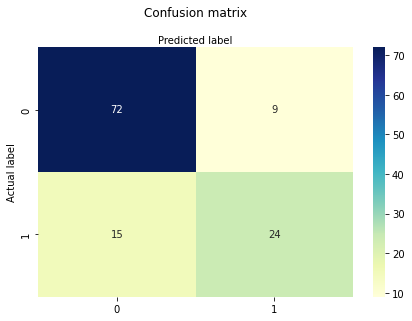

In [340]:
from sklearn.metrics import confusion_matrix
fr_pred = rf.predict(X_test)
cnf_matrix = confusion_matrix(y_test, fr_pred)
class_names=["Positive","Negative"] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print(metrics.classification_report(y_test, fr_pred))